# Examining Topics in Prepay Transcripts

In a prior notebook, we illustrated how to extract Nexidia transcripts (provided you have been approved by legal and have access). That data will be used in this notebook to illustrate how to run some basic topic modeling using Gensim.

We will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

_NOTE: This is definitely ripped off from an online tutorial, just re-worked to be Comcast specific._

### Prereq
We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

To install these, you need to run these commands from the command prompt

### Import Packages

In [93]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# display options for jupyter notebooks only
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
pd.set_option('max_colwidth', 120)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ignore those annoying depreciation warnings :)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# directory to local dataset
data_dir = Path('data/')

## Import the data

Our data comes from the Nexidia transcripts, which requires legal approval and special access. Querying the data is also quite tricky, and is handled in a different notebook altogether. For now, we assume you have the data where 1 call is on 1 row, and the transcript is in a single column.

In [3]:
indata = pd.read_csv(Path(data_dir) / 'pp.txt', sep='\t', index_col=0, low_memory=False)

# Hive exported my column headers to have the table name prefixing every column, 
# so I like to replace them to make the column names shorter
indata.columns = indata.columns.str.replace("pptrans.", "")

Let's see what the data looks like:

In [4]:
indata.head(1)

,transcript
pptrans.ucid,
10000182181560834686,YES;HERE ... IS THAT ... JUST GIVE ME A QUICK SECOND HERE TO PULL UP ACCOUNT <UNK>;<UNK>;L O;FIRST <UNK> MONTHS IT W...


### Cleaning the data

In [5]:
# Remove transcripts which are empty
indata = indata[~indata["transcript"].isnull()]
print("Number of transcripts: ", len(indata))

Number of transcripts:  241


In [6]:
# find and replace specific occurences that we're aware of
# Nexidia uses ... to signify pauses, and <UNK>/<UNKNOWN> for mumbled words
indata['transcript'] = indata['transcript'].str.replace('UNK',' ')
indata['transcript'] = indata['transcript'].str.replace('UNKNOWN',' ')
indata['transcript'] = indata['transcript'].str.replace(';',' ')

In [7]:
# Convert to list
indata_list = indata['transcript'].values.tolist()

# Remove Email addresses - this is not a danger in call transcripts but 
# we'll keep this here for other use cases
indata_list = [re.sub('\S*@\S*\s?', '', l) for l in indata_list]

# Remove new line characters
indata_list = [re.sub('\s+', ' ', l) for l in indata_list]

# Remove single quotes
indata_list = [re.sub("\'", "", l) for l in indata_list]

#print(data_words[:1])

### Stop Words
We have already downloaded some stop words. Let's bring them in, and add a few comcast specific ones.

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['comcast','xfinity'])

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(indata_list))

Now our transcript looks like this:
```
['yes', 'here', 'is', 'that', 'just', 'give', 'me', 'quick', 'second', 'here', 'to', 'pull', 'up', 'account', 'first', 'months', 'it', 'would', 'be', 'six', 'this', 'evening', 'the', 'pricing', 'for', 'thirty', 'six', 'sixteen', 'and', 'the', 'fifteen', 'twenty', 'minutes', 'id', 'like', 'to', 'speak', 'to', 'your', 'manager', 'oh', 'what', 'happened', 'how', 'sure', 'ok', 'address', 'we', 'anything', 'if', 'so', 'much', 'for', 'patiently_waiting', 'looking', 'for', 'supervisor'
...
'march', 'we', 'have', 'the', 'last', 'four', 'card', 'but', 'you', 'know', 'nine', 'sure', 'the', 'email', 'is']
```

### Creating Bigram and Trigram features
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

### Removing Stopwords, Make Bigrams and Lemmatize
Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(transcripts):
    return [[word for word in simple_preprocess(str(t)) if word not in stop_words] for t in transcripts]

def make_bigrams(transcripts):
    return [bigram_mod[t] for t in transcripts]

def make_trigrams(transcripts):
    return [trigram_mod[bigram_mod[t]] for t in transcripts]

def lemmatization(transcripts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    transcripts_out = []
    for x in transcripts:
        t = nlp(" ".join(x)) 
        transcripts_out.append([token.lemma_ for token in t if token.pos_ in allowed_postags])
    return transcripts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# if this doesnt work, re-read the beginning of this notebook, slacker
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

Now our transcript looks like this:
```
[['give', 'quick', 'second', 'pull', 'account', 'first', 'month', 'would', 'evening', 'pricing', 'minute', 'would', 'speak', 'manager', 'happen', 'sure', 'address', 'anything', 'much', 'patiently_wait'
  ...
'much', 'send', 'hand', 'much', 'patiently_wait', 'total', 'amount', 'dollar', 'point', 'march', 'last_four', 'card', 'know', 'sure', 'email']]
```

### Create the Dictionary and Corpus needed for Topic Modeling

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View (impossible to read)
print(corpus[:1])

[[(0, 2), (1, 12), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 4), (8, 2), (9, 2), (10, 2), (11, 4), (12, 2), (13, 2), (14, 4), (15, 2), (16, 10), (17, 2), (18, 2), (19, 6), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 4), (26, 2), (27, 2), (28, 2), (29, 4), (30, 2), (31, 4), (32, 2), (33, 4), (34, 2), (35, 2), (36, 2), (37, 4), (38, 2), (39, 2), (40, 2), (41, 2), (42, 4), (43, 2), (44, 4), (45, 10), (46, 4), (47, 4), (48, 2), (49, 2), (50, 4), (51, 2), (52, 2), (53, 2), (54, 2), (55, 4), (56, 2), (57, 2), (58, 2), (59, 4), (60, 2), (61, 2), (62, 4), (63, 2), (64, 2), (65, 2), (66, 2), (67, 2), (68, 4), (69, 4), (70, 2), (71, 6), (72, 4), (73, 2), (74, 2), (75, 2), (76, 6), (77, 2), (78, 2), (79, 2), (80, 2), (81, 4), (82, 2), (83, 2), (84, 2), (85, 2), (86, 4), (87, 2), (88, 4), (89, 6), (90, 4), (91, 2), (92, 2), (93, 12), (94, 2), (95, 6), (96, 6), (97, 4), (98, 4), (99, 2), (100, 2), (101, 2), (102, 2), (103, 2), (104, 2), (105, 4), (106, 4), (107, 2), (108, 2), (109, 8), (110

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [24]:
id2word[0]

'access'

Or, you can see a human-readable form of the corpus itself.

In [28]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

```
[[('access', 2),
  ('account', 12),
  ('active', 2),
  ('actually', 2),
  ('address', 2),
  ('alpha', 2),
  ('also', 2),
  ('amount', 4),
  ('anything', 2),
  ...
  ('wifi_hotspot', 2),
  ('wifi_ondemand', 2),
  ('work', 2),
  ('would', 6),
  ('yahoo_dot', 2),
  ('year', 2),
  ('youre_try', 2)]]
  ```

### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [103]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"accommodate" + 0.020*"smart" + 0.007*"procure" + 0.007*"sprite" + '
  '0.007*"medically" + 0.007*"revise" + 0.007*"gone" + 0.007*"father" + '
  '0.007*"sasseen" + 0.006*"csa"'),
 (1,
  '0.031*"card" + 0.027*"space" + 0.025*"team" + 0.022*"autopay" + '
  '0.021*"application" + 0.020*"verification" + 0.018*"permission" + '
  '0.017*"put" + 0.016*"last_four" + 0.015*"file"'),
 (2,
  '0.043*"connect" + 0.036*"password" + 0.036*"wifi" + 0.026*"try" + '
  '0.022*"network" + 0.021*"ok" + 0.020*"not" + 0.019*"internet" + '
  '0.018*"reset" + 0.017*"do"'),
 (3,
  '0.000*"service" + 0.000*"get" + 0.000*"account" + 0.000*"go" + 0.000*"know" '
  '+ 0.000*"phone" + 0.000*"not" + 0.000*"thank" + 0.000*"call" + 0.000*"be"'),
 (4,
  '0.066*"cable_department" + 0.027*"ipad" + 0.021*"consider" + '
  '0.021*"express" + 0.012*"daniel" + 0.012*"stable" + 0.012*"got" + '
  '0.011*"consumption" + 0.011*"passcode" + 0.011*"reimburse"'),
 (5,
  '0.041*"wifi" + 0.034*"computer" + 0.021*"internet"

How to interpret this?

Topic 1 is a represented as _0.028“last four” + 0.028“available” + 0.024“verification” + 0.009“account verification” ...

It means the top 10 keywords that contribute to this topic are: ‘last four’, ‘available’, ‘account verification’.. and so on.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be?

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 

In [105]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.414262048223252

Coherence Score:  0.29062165064201456


### Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [106]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.235343  0.005925       1        1  23.446140
10     0.229809 -0.011725       2        1  18.961720
12     0.228691  0.078177       3        1  12.423536
17     0.258837 -0.114260       4        1  12.161965
6      0.214897 -0.049301       5        1   9.253541
19     0.229950 -0.082712       6        1   8.401191
13     0.256317 -0.080360       7        1   7.188185
2      0.170016  0.248586       8        1   4.624358
14     0.047887  0.022001       9        1   1.622408
5     -0.057902  0.190119      10        1   0.837282
1     -0.105220 -0.100851      11        1   0.524621
4     -0.217401 -0.017146      12        1   0.176810
8     -0.220356 -0.013954      13        1   0.106346
15    -0.178668 -0.023516      14        1   0.094586
7     -0.197155 -0.008559      15        1   0.065671
0     -0.183771 -0.009103      16        1   0.041924
16    -0.181321 -0.008002      17        1   0.036502
9     -0.178324 -0.008176      18        1   0.018103
18    -0.176552 -0.009285      19        1   0.010945
3     -0.175077 -0.007858      20        1   0.004171, topic_info=    Category         Freq      Term        Total  loglift  logprob
126  Default   552.000000       use   552.000000  30.0000  30.0000
266  Default   417.000000      wifi   417.000000  29.0000  29.0000
363  Default   272.000000     today   272.000000  28.0000  28.0000
72   Default   598.000000      name   598.000000  27.0000  27.0000
165  Default   411.000000    device   411.000000  26.0000  26.0000
27   Default   326.000000   connect   326.000000  25.0000  25.0000
115  Default  1382.000000     thank  1382.000000  24.0000  24.0000
22   Default   260.000000      card   260.000000  23.0000  23.0000
315  Default   299.000000  internet   299.000000  22.0000  22.0000
222  Default   866.000000     phone   866.000000  21.0000  21.0000
..       ...          ...       ...          ...      ...      ...
3    Topic20     0.000954  actually   422.392395  -2.9164  -8.0586
77   Topic20     0.000954        ok   701.148499  -3.4232  -8.0586
72   Topic20     0.000954      name   598.401550  -3.2648  -8.0586
281  Topic20     0.000954      bill   328.691986  -2.6656  -8.0586
44   Topic20     0.000954      give   379.583618  -2.8096  -8.0586
129  Topic20     0.000954      want   437.087097  -2.9506  -8.0586
134  Topic20     0.000954      work   464.718262  -3.0119  -8.0586
96   Topic20     0.000954       say   484.047607  -3.0527  -8.0586
54   Topic20     0.000954       ill   430.424988  -2.9353  -8.0586
130  Topic20     0.000954      well   279.148102  -2.5023  -8.0586

[1357 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
578       1  0.336246           able
578       2  0.355278           able
578       3  0.085647           able
578       4  0.022205           able
578       5  0.104680           able
578       6  0.091992           able
578       7  0.006344           able
0         1  0.317443         access
0         2  0.066561         access
0         3  0.015360         access
...     ...       ...            ...
500       5  0.158627          wrong
500       7  0.059485          wrong
941       5  0.959674           xbox
1195      5  0.199565      youre_say
1195      6  0.731739      youre_say
2096      5  0.880672  youre_telling
138       2  0.039690      youre_try
138       3  0.079379      youre_try
138       5  0.317518      youre_try
138       8  0.555656      youre_try

[1972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 13, 18, 7, 20, 14, 3, 15, 6, 2, 5, 9, 16, 8, 1, 17, 10, 19, 4])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

This topic model is not that great. It needs some work, or more data (only 240 examples used in this demo)

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

### Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [76]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = str(Path(data_dir).parents[0] / 'mallet-2.0.8/bin/mallet') # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=11, id2word=id2word)

In [77]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('bill', 0.08795725441841348),
   ('month', 0.07192766132346896),
   ('payment', 0.06658446362515413),
   ('pay', 0.049732840115084255),
   ('time', 0.038635429510891904),
   ('june', 0.03247020139745171),
   ('understand', 0.030004110152075627),
   ('double', 0.02836004932182491),
   ('day', 0.027127003699136867),
   ('go_ahead', 0.02096177558569667)]),
 (6,
  [('account', 0.06084788029925187),
   ('go_ahead', 0.05885286783042394),
   ('tv', 0.0428927680798005),
   ('ill', 0.03790523690773067),
   ('connect', 0.02892768079800499),
   ('cable', 0.02743142144638404),
   ('pay', 0.026433915211970076),
   ('give', 0.02543640897755611),
   ('wifi', 0.024438902743142144),
   ('issue', 0.024438902743142144)]),
 (14,
  [('call', 0.08931552587646077),
   ('issue', 0.042153589315525875),
   ('speak', 0.03631051752921536),
   ('happen', 0.0333889816360601),
   ('system', 0.03213689482470785),
   ('make', 0.02712854757929883),
   ('time', 0.026293823038397328),
   ('hold', 0.0217028380634

### How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [78]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [79]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

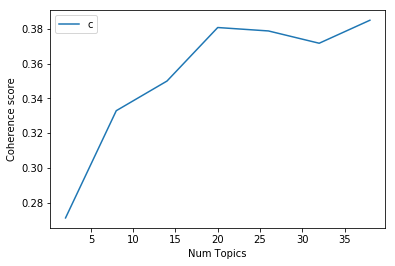

In [80]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [81]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2712
Num Topics = 8  has Coherence Value of 0.3329
Num Topics = 14  has Coherence Value of 0.3499
Num Topics = 20  has Coherence Value of 0.3807
Num Topics = 26  has Coherence Value of 0.3787
Num Topics = 32  has Coherence Value of 0.3717
Num Topics = 38  has Coherence Value of 0.3849


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [99]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.060*"account" + 0.060*"file" + 0.059*"card" + 0.049*"payment" + '
  '0.038*"last_four" + 0.038*"mobile" + 0.033*"credit_card" + 0.032*"digits" + '
  '0.024*"cent" + 0.022*"access"'),
 (1,
  '0.098*"go_ahead" + 0.092*"check" + 0.064*"end" + 0.048*"correct" + '
  '0.040*"ill" + 0.028*"issue" + 0.026*"one_moment" + 0.026*"good" + '
  '0.024*"moment" + 0.023*"alright"'),
 (2,
  '0.177*"phone" + 0.060*"device" + 0.054*"work" + 0.043*"call" + 0.030*"pay" '
  '+ 0.025*"ill" + 0.024*"long" + 0.023*"understand" + 0.021*"wanna" + '
  '0.020*"start"'),
 (3,
  '0.092*"day" + 0.073*"problem" + 0.065*"call" + 0.039*"happen" + '
  '0.037*"back" + 0.032*"work" + 0.028*"end" + 0.026*"provide" + 0.022*"give" '
  '+ 0.022*"connection"'),
 (4,
  '0.072*"connect" + 0.033*"device" + 0.023*"box" + 0.023*"purchase" + '
  '0.021*"work" + 0.020*"internet" + 0.020*"signal" + 0.018*"tv" + '
  '0.017*"hour" + 0.017*"sign"'),
 (5,
  '0.068*"pay" + 0.043*"account" + 0.039*"guy" + 0.036*"service" + '
  '0.0

### Finding the dominant topic in each transcript
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.


In [89]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=indata_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=indata_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Transcript_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Transcript_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.4061,"sir, account, refund, give, hold, dollar, pull, ill, email_address, email",YES HERE ... IS THAT ... JUST GIVE ME A QUICK SECOND HERE TO PULL UP ACCOUNT < > < > L O FIRST < > MONTHS IT WOULD B...
1,1,1.0,0.1301,"go_ahead, check, end, correct, ill, issue, one_moment, good, moment, alright",ECHO ... ARE ZERO ZERO ... ZERO ONE HOWEVER LARRY ALRIGHT ... G ... S ... T ... < > ... L ... E R ... YOU ... KNOW I...
...,...,...,...,...,...
8,8,11.0,0.1317,"call, number, laughter, thing, back, people, time, dont_know, put, worry",HER I SAID JUST START OUT WITH I JUST WANT TO USE IT FOR PHONE CALLS < > BUT THE ACCOUNT ... < > YOU HAVE A NICE ......
9,9,16.0,0.2003,"wifi, password, network, connect, check, access, internet, reset, computer, account",THAT SHOULD BE ALL IN LOWERCASE THATS ... CORRECT < > WELL NO IM JUST GONNA DO RIGHT NOW ... NO ADDRESS ... ONE SIX ...


### Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [101]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5388,"account, file, card, payment, last_four, mobile, credit_card, digits, cent, access",TO ... BUYER SO FOR THE XFINITY MOBILE ... ITS SOMETHING THAT YOU CAN DO ANY PAY LIKE < > AND WHEN YOU HAVE THE THE ...
1,1.0,0.3551,"go_ahead, check, end, correct, ill, issue, one_moment, good, moment, alright",YOU SO MUCH FOR THAT ... AND ... < > ... ALSO THE PHONE NUMBER THANK YOU SO MUCH OK YOU SAID YOURE GONNA TECHNICIAN ...
2,2.0,0.5819,"phone, device, work, call, pay, ill, long, understand, wanna, start",< > AM YES YOU HAVE A SHOW OF GOOD MY NUMBER ONE MARK I NEED TO ADD ANY CHOPPER SO HOW HOW CAN I GO ABOUT ... THE .....
3,3.0,0.2704,"day, problem, call, happen, back, work, end, provide, give, connection",< > DO GOT THAT NOW UM ... STATING THANK < > THE TOP ONE NETWORK SETTINGS TO ... OK OK ... ALRIGHT THANK YOU < > REA...
4,4.0,0.7139,"connect, device, box, purchase, work, internet, signal, tv, hour, sign",HAVE NO LIKE CONNECT ME TO MAYBE THE PERSON SO I COULD TALK TO ... ABOUT IT I ... DOING THAT BUT IS THERE ANYWAY I ....
5,5.0,0.6139,"pay, account, guy, service, department, update, internet, give, cable, channel",CORRECT EXACTLY IM GETTING THE RIGHT ACCOUNT WORRIED ME PLEASE THANK YOU ... AND IM I SPEAKING WITH AND ALSO THEY WI...
6,6.0,0.7398,"sir, account, refund, give, hold, dollar, pull, ill, email_address, email",M A R SO FOR HOW MANY DAYS ... THE UPDATED BALANCE SIR ... I THINK IT WAS ABOUT FIFTY SOMETHING I DONT RECALL YES < ...
7,7.0,0.6354,"card, account, service, number, phone_number, online, change, give, call, pin",YES YOURE MY FINANCE CHARGE ... < > IT WAS IT I DONT KNOW MY PIN IS FOR MY ACCOUNT ... CLICK HERE ... PAY IT ... YOU...
8,8.0,0.4770,"maam, account, internet, time, ill, pull, may_know, verify, area, service_address",< > AND YES < > SIX FIVE ... THREE ... < > ... SOUTH MADISON STREET ... IN ADRIAN MICHIGAN ... FOUR NINE TWO TWO ONE...
9,9.0,0.7060,"bill, payment, month, go_ahead, pay, june, double, time, service, day",MUCH ... < > OK MAY IN JUNE ... THATS WHY IM WONDERING IF ... DOUBLE ... IF THEY DOUBLE BILLED ME FOR SOMEBODY DOUBL...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.


In [109]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"sir, account, refund, give, hold, dollar, pull, ill, email_address, email",27.0,0.1120
1,1.0,"go_ahead, check, end, correct, ill, issue, one_moment, good, moment, alright",15.0,0.0622
2,7.0,"card, account, service, number, phone_number, online, change, give, call, pin",7.0,0.0290
3,18.0,"modem, work, connect, back, technician, check, internet, light, mister, service",8.0,0.0332
4,1.0,"go_ahead, check, end, correct, ill, issue, one_moment, good, moment, alright",6.0,0.0249
5,17.0,"dollar, bill, charge, month, line, buy, switch, mobile, free, forty_five",7.0,0.0290
6,4.0,"connect, device, box, purchase, work, internet, signal, tv, hour, sign",13.0,0.0539
7,15.0,"mobile, call, department, hear, guy, today, line, open, tomorrow, phone_number",11.0,0.0456
8,11.0,"call, number, laughter, thing, back, people, time, dont_know, put, worry",20.0,0.0830
9,16.0,"wifi, password, network, connect, check, access, internet, reset, computer, account",4.0,0.0166
